In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc

In [2]:
%matplotlib widget

In [3]:
%matplotlib inline

In [4]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")

In [5]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [6]:
f.keys()

<KeysViewHDF5 ['t', 'wamos', 'x', 'y']>

In [7]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [8]:
wamos

array([[[1417., 1810., 1348., ..., 1177., 1248., 1290.],
        [1683., 1587., 1656., ..., 1081., 1170., 1122.],
        [1746., 1693., 1896., ..., 1224., 1224.,  660.],
        ...,
        [1660., 2165., 2723., ..., 1741., 1838., 1814.],
        [1199., 1753., 2969., ..., 1440., 1491., 1646.],
        [1723., 1653., 2290., ..., 1368., 1273., 1381.]],

       [[1779., 1694., 1774., ..., 1146., 1200., 1333.],
        [1308., 1824., 1347., ..., 1282., 1738., 1980.],
        [1929., 1298., 1786., ..., 1466., 1441., 1760.],
        ...,
        [1134., 2025., 2094., ...,  768.,  664.,  721.],
        [1568., 1677., 2112., ...,  997.,  997.,  982.],
        [1641., 2246., 2260., ...,  963.,  705.,  983.]],

       [[2277., 2936., 3201., ..., 1344., 1027.,  928.],
        [3079., 3297., 3528., ..., 1054.,  916.,    0.],
        [2953., 3462., 2245., ...,  984.,  984., 1095.],
        ...,
        [2587., 2659., 2471., ..., 1701., 1628., 1378.],
        [2107., 2596., 2766., ..., 1192., 119

In [9]:
np.max(wamos)

4095.0

In [10]:
x

array([-247.5 , -243.75, -240.  , -236.25, -232.5 , -228.75, -225.  ,
       -221.25, -217.5 , -213.75, -210.  , -206.25, -202.5 , -198.75,
       -195.  , -191.25, -187.5 , -183.75, -180.  , -176.25, -172.5 ,
       -168.75, -165.  , -161.25, -157.5 , -153.75, -150.  , -146.25,
       -142.5 , -138.75, -135.  , -131.25, -127.5 , -123.75, -120.  ,
       -116.25, -112.5 , -108.75, -105.  , -101.25,  -97.5 ,  -93.75,
        -90.  ,  -86.25,  -82.5 ,  -78.75,  -75.  ,  -71.25,  -67.5 ,
        -63.75,  -60.  ,  -56.25,  -52.5 ,  -48.75,  -45.  ,  -41.25,
        -37.5 ,  -33.75,  -30.  ,  -26.25,  -22.5 ,  -18.75,  -15.  ,
        -11.25,   -7.5 ,   -3.75,    0.  ,    3.75,    7.5 ,   11.25,
         15.  ,   18.75,   22.5 ,   26.25,   30.  ,   33.75,   37.5 ,
         41.25,   45.  ,   48.75,   52.5 ,   56.25,   60.  ,   63.75,
         67.5 ,   71.25,   75.  ,   78.75,   82.5 ,   86.25,   90.  ,
         93.75,   97.5 ,  101.25,  105.  ,  108.75,  112.5 ,  116.25,
        120.  ,  123

In [11]:
t.shape

(366,)

In [12]:
wamos.shape

(366, 132, 132)

In [13]:
y[4] - y[5]

-3.75

In [14]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]

In [15]:
wamos.shape

(366, 132, 132)

In [16]:
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))
dk

0.01269330365086785

In [17]:
wavenumbers = np.arange(3 * dk, 0.35, dk)
wavenumbers

array([0.03807991, 0.05077321, 0.06346652, 0.07615982, 0.08885313,
       0.10154643, 0.11423973, 0.12693304, 0.13962634, 0.15231964,
       0.16501295, 0.17770625, 0.19039955, 0.20309286, 0.21578616,
       0.22847947, 0.24117277, 0.25386607, 0.26655938, 0.27925268,
       0.29194598, 0.30463929, 0.31733259, 0.33002589, 0.3427192 ])

# 1) NSP Method

## 1.1) NSP Implementation

In [18]:
maxFrequency = 4.0 

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

frequencyLimits = [0.01, 20.0]
# frequency limits for masking the spectrum [min max], rad/sec

Ux_limits = [-1, 1]
# Ux current limits [m/s]

Uy_limits = [-1, 1]
# Uy current limts [m/s]

U_res = 0.1
# Current step size [m/s]

omegaWidthFun = lambda k: 0.05 + 0.0 * k

In [19]:
Uym, Uxm = np.meshgrid(np.arange(min(Uy_limits), max(Uy_limits) + U_res, U_res),
                       np.arange(min(Ux_limits), max(Ux_limits) + U_res, U_res))

In [20]:
h = np.inf
g = 9.81
T = 0.072 / 1000

In [21]:
from scipy.fftpack import fftn, fftshift

def retrieve_power_spectrum(IMG_3D, dx, dy, dt, K_limits=None, W_limits=None):
    # Set default values for K_limits and W_limits if not provided
    if K_limits is None:
        K_limits = [-np.inf, np.inf]
    if W_limits is None:
        W_limits = [-np.inf, np.inf]

    # Check limits
    if any(np.array(K_limits) < 0):
        print('retrieve_positive_spectrum: K_limits smaller than 0')
    if any(np.array(W_limits) < 0):
        print('retrieve_positive_spectrum: W_limits smaller than 0')

    # Get Kx, Ky, and w axes
    Nt, Nx, Ny = IMG_3D.shape
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    Norm = dKx * dKy * dW

    # Get power spectra
    Spectrum_raw = fftshift(fftn(IMG_3D) / np.prod(IMG_3D.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2

    # Get index boundaries
    ind_x = np.abs(Kx) <= K_limits[1]
    ind_y = np.abs(Ky) <= K_limits[1]
    ind_w = (w >= W_limits[0]) & (w <= W_limits[1])

    # Create 3D structure using meshgrid
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

    # Use np.ix_ for boolean indexing to extract the desired values
    power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

    # Set to NaN values outside K_limits
    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < K_limits[0]) | (K_3D > K_limits[1])] = np.nan

    # Get original spectrum limits
    Kx_orig_limits = [Kx[0], Kx[-1]]
    Ky_orig_limits = [Ky[0], Ky[-1]]
    W_orig_limits = [w[0], w[-1]]

    # Normalize spectra (sum(power_Spectrum_cut(:)) = 1)
    power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

    # Create output structure
    Spectrum = {'power_Spectrum': power_Spectrum_cut,
                'Kx_3D': Kx_3D, 'Ky_3D': Ky_3D, 'W_3D': W_3D,
                'dKx': dKx, 'dKy': dKy, 'dW': dW,
                'Kx_orig_limits': Kx_orig_limits, 'Ky_orig_limits': Ky_orig_limits,
                'W_orig_limits': W_orig_limits}

    return Spectrum

In [22]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    
    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers)}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    return out_fit

In [23]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G

In [24]:
wavenumberLimits = []

for jj in range(len(wavenumbers)):
    wavenumberLimits_range = wavenumbers[jj] + kW * np.array([-1,1])
    wavenumberLimits.append(wavenumberLimits_range)

In [25]:
Spectrum_at_k = []

ind_x_at_k = []
ind_y_at_k = []
ind_w_at_k = []

W_3D_at_k = []
Kx_3D_at_k = []
Ky_3D_at_k = []

Ux_at_k = []
Uy_at_k = []

SNR_max_at_k = []

snrG_at_k = []

im_at_k = []
cDoppGuess_at_k = []

Ux_at_k_correct = []
Uy_at_k_correct = []

# Initialize the tqdm progress bar outside the loop
progress_bar = tqdm(total=len(wavenumberLimits), desc="Processing wavenumbers")

for i in range(len(wavenumberLimits)):
    # i is the index of each wavenumber
    
    fit_param = {'wavenumbers': wavenumbers[i],
     'include2ndHarmonic': 0,
     'logFlag': [],
     'SNR_filter': 0,
     'SNR_threshold': 1,
     'Peak_filter': 0,
     'Peak_threshold': 0.5,
     'Outlier_filter': 0,
     'kWidth': 0.050015405430285265,
     'Ux_2D': Uxm, 
     'Uy_2D': Uym}
    
    P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}
    
    Spectrum = retrieve_power_spectrum(wamos, dx, dy, dt, K_limits=wavenumberLimits[i], W_limits=frequencyLimits)
    Spectrum_at_k.append(Spectrum)
    
    Nt, Nx, Ny = wamos.shape
    
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values
    # w = spec3d.get_C()[0]
    # Kx = spec3d.get_C()[1]
    # Ky = spec3d.get_C()[2]
    
    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    # kx, ky and w resolution
    
    Norm = dKx * dKy * dW
    
    # Get power spectra (1200, 67, 67)
    Spectrum_raw = fftshift(fftn(wamos) / np.prod(wamos.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2
    # ?? how is this related to FFT spec3d.spectrum()
    
    ind_x = np.abs(Kx) <= wavenumberLimits[i][1]
    ind_x_at_k.append(ind_x)
    ind_y = np.abs(Ky) <= wavenumberLimits[i][1]
    ind_y_at_k.append(ind_y)
    # Is the absolute values of Kx and Ky smaller than the upper value of the wavenumber range 
    
    ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    ind_w_at_k.append(ind_w)
    # Is the value of w between the frequency limits 0.01 and 20 
    
    # Create 3D structure where it only includes w,Kx,Ky that are in the ranges required by wavenumberLimits
    W_3D, Kx_3D, Ky_3D = np.meshgrid( w[ind_w_at_k[i]], Kx[ind_x_at_k[i]] , Ky[ind_y_at_k[i]] , indexing='ij')
    W_3D_at_k.append(W_3D)
    Kx_3D_at_k.append(Kx_3D)
    Ky_3D_at_k.append(Ky_3D)
    
    
    Ux_2D = Uxm
    Uy_2D = Uym
    
    snrG = np.zeros(Ux_2D.shape)
    
    for m in range(Ux_2D.shape[0]):
        for n in range(Ux_2D.shape[1]):
            snr_mn, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers[i], Ux_2D[m, n], Uy_2D[m, n])
            snrG[m, n] = snr_mn
            
            
    snrG_at_k.append(snrG)
    # Append the 2D array to the list
    
    
    im = np.argmax(snrG_at_k[i])
    im_at_k.append(im)
    
    if np.ndim(Ux_2D) == 1:
        cDoppGuess = Ux_2D[im]
    else:
        Ux_1D = Ux_2D.flatten()
        Uy_1D = Uy_2D.flatten()
        cDoppGuess = [Ux_1D[im], Uy_1D[im]]
    
    cDoppGuess_at_k.append(cDoppGuess)
    
    
    Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], cDoppGuess)
    
    Ux = Ufit.x[0]
    Uy = Ufit.x[1]
    
    Ux_at_k_correct.append(Ux)
    Uy_at_k_correct.append(Uy)
    
    # Update the tqdm progress bar
    progress_bar.update(1)

# Close the tqdm progress bar after the loop is finished
progress_bar.close()

Processing wavenumbers: 100%|██████████| 25/25 [01:48<00:00,  4.33s/it]


In [26]:
Ux = np.array(Ux_at_k_correct)
Uy = np.array(Uy_at_k_correct)

Text(0.5, 1.0, 'Effective Current $|U|$')

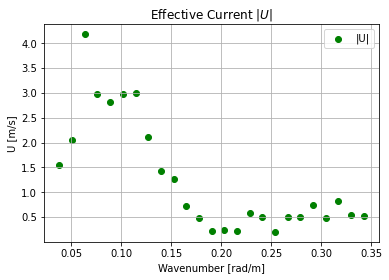

In [27]:
#plt.scatter(wavenumbers, np.abs(Ux), label='Ux', color = 'blue')
#plt.scatter(wavenumbers, np.abs(Uy), label='Uy', color = 'red')
plt.scatter(wavenumbers, np.sqrt(Ux**2+Uy**2), label='|U|', color = 'green')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title('Effective Current $|U|$')

#plt.ylim(0, 1)
#plt.xlim(0, 0.31)

## 1.2) Fitting Higher Wavenumbers

In [28]:
x1 = wavenumbers
y1 = np.sqrt(Ux**2+Uy**2)

In [29]:
x1.shape

(25,)

In [30]:
x1[9]

0.15231964381041418

In [31]:
y1[9]

1.2593068332353592

In [32]:
#filtered_x = np.insert( x1, 0, 0)
#filtered_y = np.insert( y1, 0, 0)
# add (0,0) as a point

filtered_x = np.insert( x1, 0, 1*10**-8)
filtered_y = np.insert( y1, 0, 1*10**-8)

In [33]:
def cubic(x):
    return 3*(x-1)**3-x**2-4*x+5

## 1.2.1) Fit Power Law

In [34]:
def fpow(x, a, b, c):
    return a*x**b+c

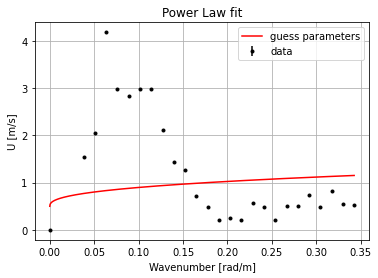

In [35]:
# plot the raw data
plt.errorbar(filtered_x, filtered_y, yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")

# initial guess
pars0 = (1, 0.4, 0.5)
 
x = np.linspace(0, max(filtered_x), 1000)

plt.plot(x, fpow(x,*pars0), color = 'red', label = 'guess parameters')
plt.legend();
plt.title("Power Law fit");

C:\Users\josep\Documents\Anaconda\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


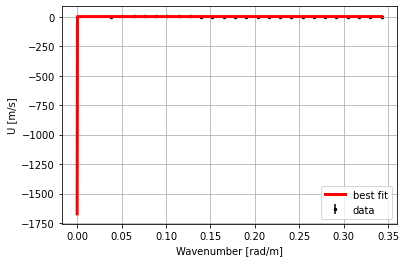

In [36]:
# perform fitting
popt, pcov = curve_fit(fpow, filtered_x, filtered_y, absolute_sigma=True, p0=pars0, maxfev =2000)

# Parameters
a_opt = popt[0]
b_opt = popt[1]
c_opt = popt[2]

# plot data
plt.errorbar(filtered_x, filtered_y, yerr=0, fmt=".", color = 'black', label = 'data', zorder=1, markersize = 5)

# creating x interval to include in y fit
x = np.linspace(0.0, max(filtered_x), 1000)
y_fit = fpow(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit", zorder=2, linewidth = 3)

plt.grid(True)
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.legend();

## 1.2.2) Fit Residuals

In [37]:
def fitted_power(x):
    return a_opt*x**b_opt+c_opt

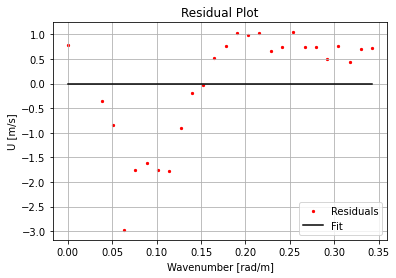

In [38]:
plt.scatter(filtered_x, fitted_power(filtered_x) - filtered_y, s = 5 , label='Residuals', color = 'red')
plt.plot(x, np.zeros(len(x)), label = 'Fit', color = 'black')

plt.grid(True)
plt.title('Residual Plot')
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.legend()

#plt.ylim(-5,5)

## 1.2.3) Weighted Least Squares

In [39]:
filtered_x

array([1.00000000e-08, 3.80799110e-02, 5.07732146e-02, 6.34665183e-02,
       7.61598219e-02, 8.88531256e-02, 1.01546429e-01, 1.14239733e-01,
       1.26933037e-01, 1.39626340e-01, 1.52319644e-01, 1.65012947e-01,
       1.77706251e-01, 1.90399555e-01, 2.03092858e-01, 2.15786162e-01,
       2.28479466e-01, 2.41172769e-01, 2.53866073e-01, 2.66559377e-01,
       2.79252680e-01, 2.91945984e-01, 3.04639288e-01, 3.17332591e-01,
       3.30025895e-01, 3.42719199e-01])

In [40]:
filtered_y

array([1.00000000e-08, 1.53989397e+00, 2.04460628e+00, 4.18043213e+00,
       2.97621482e+00, 2.82642339e+00, 2.98335023e+00, 2.98964836e+00,
       2.12218901e+00, 1.42801972e+00, 1.25930683e+00, 7.16440766e-01,
       4.82208656e-01, 2.11659851e-01, 2.47566092e-01, 2.11231786e-01,
       5.73449986e-01, 4.93627624e-01, 2.02827667e-01, 5.03211858e-01,
       5.03471650e-01, 7.42594082e-01, 4.84937826e-01, 8.17855876e-01,
       5.45436664e-01, 5.32188379e-01])

In [41]:
def f(x):
    return x^2

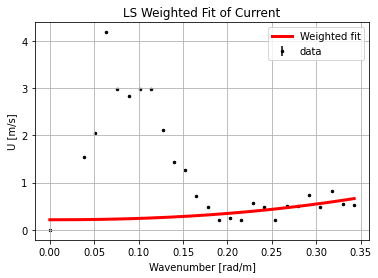

In [42]:
# fitted function
def fpow(x, a, b, c):
    return a*x**b+c

# custom weight function
def custom_weights(x):
    weights = np.ones_like(x)  # Default weight for all points
    weights[np.isclose(x, 0, atol=1e-7)] = 0.05  # Low Error for x = 0
    weights[x > 0.2] = 0.5 # Low Error for x > 0.15
    weights[(0 < x) & (x <= 0.2)] = 10  # Medium error for 0 < x <= 0.2
    return weights

# initial guess
pars0 = (0.4, 0.4, 1)

# perform fitting with custom weights
popt, pcov = curve_fit(fpow, filtered_x, filtered_y, absolute_sigma=True, p0=pars0, sigma=custom_weights(filtered_x), maxfev =5000)

# parameters
a_opt = popt[0]
b_opt = popt[1]
c_opt = popt[2]

# plot data
plt.errorbar(filtered_x, filtered_y, yerr=0, fmt =".", color='black', label ='data', zorder=1, markersize=5)

# creating x interval to include in y fit
x_interval = np.linspace(0, max(filtered_x), 1000)
y_fit = fpow( x_interval , *popt)
plt.plot( x_interval, y_fit, color = "red", label = "Weighted fit", zorder=2 , linewidth=3)

plt.grid(True)
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("LS Weighted Fit of Current")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Effective Current $|U|$')

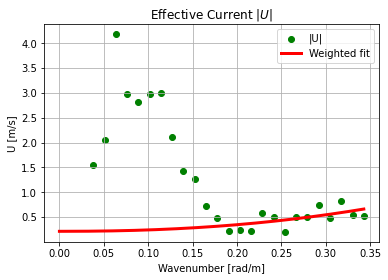

In [43]:
plt.scatter(wavenumbers, np.sqrt(Ux**2+Uy**2), label='|U|', color = 'green')
plt.plot( x_interval, y_fit, color = "red", label = "Weighted fit", zorder=2 , linewidth=3)


plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title('Effective Current $|U|$')

In [44]:
p = np.poly1d(np.polyfit(wavenumbers, y1, 10))

In [45]:
Uk_mask = np.where(np.gradient(p(wavenumbers))>0, 1, 0)

In [46]:
k_m = np.block([0, np.ma.masked_array(wavenumbers, mask=1-Uk_mask).compressed()])
Uk_m = np.block([0, np.ma.masked_array(y1, mask=1-Uk_mask).compressed()])

Text(0.5, 0, 'Wavenumber [rad/m]')

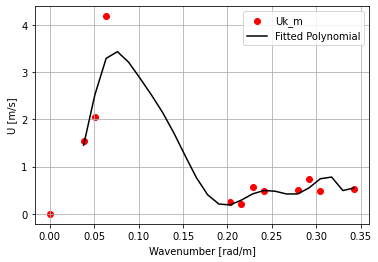

In [47]:
plt.scatter(k_m, Uk_m, label='Uk_m', color = 'red')
plt.plot(wavenumbers, p(wavenumbers), label='Fitted Polynomial', color='black')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")

# 1.2) PCS Method

In [48]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [49]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [50]:
wamos.shape

(366, 132, 132)

In [51]:
eta = np.transpose(wamos, (1, 2, 0))

In [52]:
wamos[200,17,13]

1524.0

In [53]:
eta[17,13,200]

1524.0

In [54]:
eta.shape

(132, 132, 366)

In [55]:
# new version with eta changed dimension 
def cylinder_cross_section(Spectrum, dtheta, power_Spectrum_cut , order=None):
    if order is None:
        order = 4

    Kx_2D = np.squeeze(Kx_3D[:,:,0])
    Ky_2D = np.squeeze(Ky_3D[:,:,0])
    W_1D = np.squeeze(W_3D[0,0,:])

    theta_2D = np.arctan2(-Ky_2D, -Kx_2D)
    theta_3D = np.tile(theta_2D[:, :, np.newaxis], (1, 1, W_1D.size))

    theta_vals = np.arange(-np.pi, np.pi, dtheta)
    S_cyl = np.zeros((W_1D.size, theta_vals.size))

    for ii in range(theta_vals.size):
        theta_diff = np.angle(np.exp(1j * theta_3D) * np.exp(-1j * theta_vals[ii]))
        theta_filt = np.exp(-2 * (theta_diff / dtheta) ** order)
        S_filt = power_Spectrum_cut * theta_filt
        S_cyl[:, ii] = np.nansum(S_filt, axis=(0, 1))

    thetaM, omegaM = np.meshgrid(theta_vals, W_1D)

    Scyl = {
        'P_k': S_cyl,
        'thetaM': thetaM,
        'omegaM': omegaM,
        'Kx_2D': Kx_2D, 
        'Ky_2D': Ky_2D,
        'W_1D': W_1D,
        'theta_2D':theta_2D,
        'theta_3D':theta_3D,
        'theta_vals':theta_vals,
        'theta_diff':theta_diff,
        'theta_filt':theta_filt
    }

    return Scyl

In [56]:
dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
dk

0.01269330365086785

In [57]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [58]:
Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

In [59]:
w

array([-1.27409035, -1.26712811, -1.26016587, -1.25320363, -1.24624138,
       -1.23927914, -1.2323169 , -1.22535466, -1.21839241, -1.21143017,
       -1.20446793, -1.19750569, -1.19054345, -1.1835812 , -1.17661896,
       -1.16965672, -1.16269448, -1.15573223, -1.14876999, -1.14180775,
       -1.13484551, -1.12788326, -1.12092102, -1.11395878, -1.10699654,
       -1.10003429, -1.09307205, -1.08610981, -1.07914757, -1.07218533,
       -1.06522308, -1.05826084, -1.0512986 , -1.04433636, -1.03737411,
       -1.03041187, -1.02344963, -1.01648739, -1.00952514, -1.0025629 ,
       -0.99560066, -0.98863842, -0.98167617, -0.97471393, -0.96775169,
       -0.96078945, -0.9538272 , -0.94686496, -0.93990272, -0.93294048,
       -0.92597824, -0.91901599, -0.91205375, -0.90509151, -0.89812927,
       -0.89116702, -0.88420478, -0.87724254, -0.8702803 , -0.86331805,
       -0.85635581, -0.84939357, -0.84243133, -0.83546908, -0.82850684,
       -0.8215446 , -0.81458236, -0.80762012, -0.80065787, -0.79

In [60]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [61]:
Norm = dKx * dKy * dW 

In [62]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [63]:
power_Spectrum.shape

(132, 132, 366)

## 1.2.1) HP Filter

In [64]:
I_0 = power_Spectrum
I_0.shape

(132, 132, 366)

In [65]:
w_cut = 0.03 * 2*np.pi

In [66]:
w_cut

0.18849555921538758

In [67]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [68]:
I_1 = np.where(mask[ None, None,:], I_0, 0)

## 1.2.2)Energy Threshold

In [69]:
# Create a boolean mask based on the condition energy

P = np.max(I_1) / 1000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [70]:
I_2 = np.where(condition[:, :, None], I_1, 0)

## 1.2.3) Peak Identification

In [71]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [72]:
def check_prominent_peaks(kx, ky):
    y = I_2[kx, ky,:]
    
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
        
    else:
        peak_heights = y
        
        # Find the peak with the maximum height
        max_peak_index = np.argmax(peak_heights)
        max_peak_height = peak_heights[max_peak_index]

        threshold = 6

        # Check if the maximum peak 6 times larger than the others
        # If it is we conclude it is a peak on its own and print
        if max_peak_height > threshold * np.max(peak_heights[peak_heights != max_peak_height]):
            wj[kx,ky] = w[max_peak_index]
            
        else:
            pass
            
    return wj

In [73]:
def identification(kx, ky, ratio, prominence, distance):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)
        order = np.flip(np.argsort(stats["prominences"]))

        if len(peaks) == 1:
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            for i, j in zip(order[:-1], order[1:]):
                if stats["prominences"][i] >= ratio * stats["prominences"][j]:
                    wj[kx,ky] = w[peaks[i]]
                    
#        return {
#            "values": values,
#            "order": order,
#            "peaks": peaks,
#            "stats": stats,
#        }
    
    return wj 

In [74]:
def identification(kx, ky, ratio, prominence, distance):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)

        if len(peaks) == 1:
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            try_sort = list(set(y[peaks]))
            try_sort.sort()
            ind = np.where(y[peaks]==np.max(y[peaks]))
            thing = []

            for k in range(len(peaks)):
                if np.max(y[peaks]) >= ratio*try_sort[-2]:
                    #thing.append(w[peaks[ind]])
                    wj[kx,ky] = w[peaks[ind]]
                    
#        return {
#            "values": values,
#            "order": order,
#            "peaks": peaks,
#            "stats": stats,
#        }
    
    return wj 

# Testing data

In [452]:
l = 36

y = I_2[nonzero_indices[0][l], nonzero_indices[1][l],:]
peaks, stats = find_peaks(y, prominence=0.1*np.max(y), distance=10)

IndexError: index 36 is out of bounds for axis 0 with size 14

In [453]:
plt.scatter(w, I_2[nonzero_indices[0][l], nonzero_indices[1][l], :])

for i in w[peaks]:
    plt.axvline(i, color='red')

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)
plt.title("Should be counted")

IndexError: index 36 is out of bounds for axis 0 with size 14

In [454]:
order = np.flip(np.argsort(stats["prominences"]))
thing = []
ratio = 3

In [455]:
# When there is more than one peak 
thing = []
for i, j in zip(order[:-1], order[1:]):
    if stats["prominences"][i] >= ratio * stats["prominences"][j]:
        thing.append(w[peaks[i]])

In [456]:
try_sort = list(set(y[peaks]))
try_sort.sort()
ind = np.where(y[peaks]==np.max(y[peaks]))
thing = []

for k in range(len(peaks)):
    if np.max(y[peaks]) >= ratio*try_sort[-2]:
        thing.append(w[peaks[ind]])

IndexError: index 274 is out of bounds for axis 0 with size 132

In [457]:
plt.scatter(w, I_2[nonzero_indices[0][l], nonzero_indices[1][l],:])

for i in thing:
    plt.axvline(i, color='green')

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)
plt.title("Gets Counted")

IndexError: index 36 is out of bounds for axis 0 with size 14

In [127]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=3, prominence=0.1*np.max(y), distance=10))

In [128]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

In [129]:
w0 = w0_2D[w0_2D != 0]

In [130]:
nonzero_indices = np.nonzero(w0_2D)

In [131]:
nonzero_indices

(array([51, 51, 53, 54, 54, 54, 54, 55, 55, 56, 56, 56, 57, 58, 58, 59, 59,
        59, 60, 60, 60, 61, 61, 61, 62, 62, 63, 63, 63, 63, 63, 63, 64, 64,
        64, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68,
        68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 71,
        71, 71, 72, 72, 72, 72, 73, 75, 76, 77], dtype=int64),
 array([56, 57, 57, 54, 55, 57, 58, 54, 56, 53, 54, 55, 51, 50, 53, 53, 54,
        78, 49, 51, 53, 50, 52, 53, 73, 80, 49, 53, 69, 73, 74, 76, 70, 72,
        73, 72, 73, 54, 67, 72, 74, 67, 68, 69, 73, 74, 49, 53, 54, 68, 69,
        70, 72, 73, 80, 48, 54, 67, 68, 69, 74, 54, 67, 68, 73, 75, 76, 49,
        67, 74, 50, 65, 67, 73, 49, 80, 76, 75], dtype=int64))

In [132]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

In [133]:
kx_indices

array([51, 51, 53, 54, 54, 54, 54, 55, 55, 56, 56, 56, 57, 58, 58, 59, 59,
       59, 60, 60, 60, 61, 61, 61, 62, 62, 63, 63, 63, 63, 63, 63, 64, 64,
       64, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68,
       68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 71,
       71, 71, 72, 72, 72, 72, 73, 75, 76, 77], dtype=int64)

In [134]:
ky_indices.shape

(78,)

In [135]:
ky_indices.shape

(78,)

In [136]:
kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [137]:
ky_trip

array([-0.12693304, -0.11423973, -0.11423973, -0.15231964, -0.13962634,
       -0.11423973, -0.10154643, -0.15231964, -0.12693304, -0.16501295,
       -0.15231964, -0.13962634, -0.19039955, -0.20309286, -0.16501295,
       -0.16501295, -0.15231964,  0.15231964, -0.21578616, -0.19039955,
       -0.16501295, -0.20309286, -0.17770625, -0.16501295,  0.08885313,
        0.17770625, -0.21578616, -0.16501295,  0.03807991,  0.08885313,
        0.10154643,  0.12693304,  0.05077321,  0.07615982,  0.08885313,
        0.07615982,  0.08885313, -0.15231964,  0.0126933 ,  0.07615982,
        0.10154643,  0.0126933 ,  0.02538661,  0.03807991,  0.08885313,
        0.10154643, -0.21578616, -0.16501295, -0.15231964,  0.02538661,
        0.03807991,  0.05077321,  0.07615982,  0.08885313,  0.17770625,
       -0.22847947, -0.15231964,  0.0126933 ,  0.02538661,  0.03807991,
        0.10154643, -0.15231964,  0.0126933 ,  0.02538661,  0.08885313,
        0.11423973,  0.12693304, -0.21578616,  0.0126933 ,  0.10

In [138]:
ky_trip.shape

(78,)

In [139]:
ky_trip.shape

(78,)

In [88]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

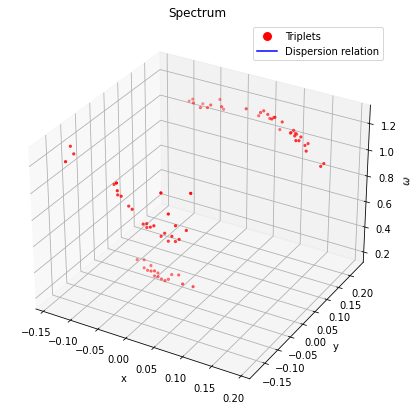

In [89]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0, color = "red", s = 5)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\omega$')

# Create legend manually with a dot for 'Triplets'
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Triplets'),
    mlines.Line2D([0], [0], color='blue', label='Dispersion relation')
]

# Create legend
ax.legend(handles=legend_elements)
 
# show plot
plt.show()

# 1.2.?) Try filter out bad triplets

In [148]:
w0_2D.shape

(132, 132)

In [149]:
# Create a mask based on Ky values
mask = -Kx < -0.07

In [150]:
# Apply the mask to the 2D array
w0_2D_filtered = np.where(mask[np.newaxis, :], w0_2D, 0)

In [151]:
np.max(w0_2D)

1.2601658692131736

In [152]:
yoke1, yoke2 = np.meshgrid(-Kx, -Ky, indexing='ij')

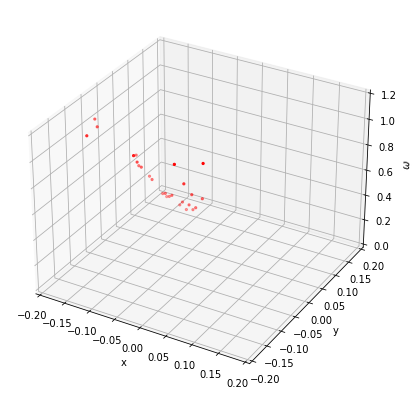

In [154]:
# Flatten the 2D arrays
x_flat = yoke1.flatten()
y_flat = yoke2.flatten()
z_flat = w0_2D_filtered.flatten()

# Filter out points where z-data is 0
non_zero_indices = np.where(z_flat != 0)
x_filtered = x_flat[non_zero_indices]
y_filtered = y_flat[non_zero_indices]
z_filtered = z_flat[non_zero_indices]

# Create a 3D plot
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\omega$')

# Scatter plot the points
ax.scatter(x_filtered, y_filtered, z_filtered, c='r', marker='o', s = 5)

#ax.scatter3D(-kx_trip, -ky_trip, w0, color = "green", s = 5)

In [155]:
w0_2D = w0_2D_filtered

## 1.2.4) Convert to polars

In [140]:
from scipy.stats import t

In [141]:
# kx_2D, ky_2D= np.meshgrid(kx_trip, ky_trip, indexing='ij')
kx_2D, ky_2D= np.meshgrid(Kx, Ky, indexing='ij')

In [142]:
K_2D = np.sqrt(kx_2D**2 + ky_2D**2)
theta_2D = np.arctan2(ky_2D, kx_2D)

## 1.2.5) Find Effective Current

In [143]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b) 

In [144]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [145]:
cut_k_array = np.arange(0.001, 0.35, 0.001)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]

    #reso = 0.02
    # dk - either side of cut cylinder
    #ind = np.where(((k_slice - reso) < K_2D ) & ( K_2D < (k_slice + reso)))
    
    ind = np.where(np.round(K_2D, 2) == k_slice)
    
    # Slice at wavenumber cut_k - once k is within 0.01 it is counted as a slice
    w0_is_k = w0_2D[ind[0], ind[1]]
    theta_is_k = theta_2D[ind[0], ind[1]]
    
    # w and theta values along k_slice
    inds_where_w0_nonzero = np.where(w0_is_k != 0)
    
    if len(inds_where_w0_nonzero[0]) > 1:
        # How many nonzero w0 theres needs to be to be counted (increased numbers, increases accuracy)
        nonzero_theta_at_k = theta_is_k[inds_where_w0_nonzero]
        nonzero_w0_at_k = w0_is_k[inds_where_w0_nonzero]
        
        x_theta = nonzero_theta_at_k
        y_theta = (nonzero_w0_at_k - np.sqrt(9.81 * k_slice)) / k_slice
        
        # Preform Grubbs test to remove outliers
        x_theta, y_theta = grubbs_test(x_theta, y_theta)
        
        # Fitting Cos onto points
        pars0 = (max(y_theta), 1)  # initial guess
        popt, pcov = curve_fit(sinusoidinal, x_theta, y_theta, absolute_sigma=True, p0=pars0)
        
        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
        # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    else:
        # If no values in inds_where_w0_nonzero, append None or a placeholder value as needed
        U_array.append(None)
        Φ_array.append(None)

<ipython-input-144-f85b713f9694>:11: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((y - mean_data) / std_data)


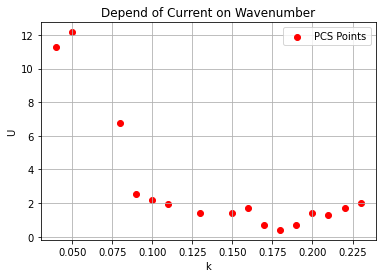

In [146]:
plt.scatter(cut_k_array, U_array, color = 'red', label = 'PCS Points')
#plt.plot(k, Uk[:,0], color = 'black', linestyle = '--',  label='Correct U')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
#plt.xlim(0.15, 0.2)
#plt.ylim(0,3)

(-3.141592653589793, 3.141592653589793)

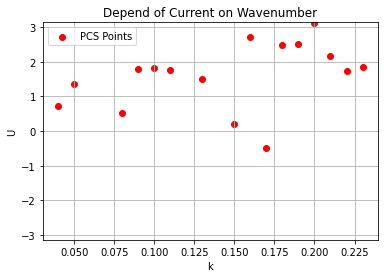

In [147]:
plt.scatter(cut_k_array,Φ_array, color = 'red', label = 'PCS Points')
#plt.plot(k, Uk[:,0], color = 'black', linestyle = '--',  label='Correct U')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
plt.ylim(-np.pi,np.pi)

## 1.2.6) Plot disp surface

In [106]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

In [107]:
dk = 0.005
k = np.arange(0.01, 0.35, dk)
k.shape

(68,)

In [108]:
z.shape

NameError: name 'z' is not defined

In [109]:
len(U_array[:26])

26

In [110]:
z_arra = np.linspace(-20, 0, 26)
z_arra

array([-20. , -19.2, -18.4, -17.6, -16.8, -16. , -15.2, -14.4, -13.6,
       -12.8, -12. , -11.2, -10.4,  -9.6,  -8.8,  -8. ,  -7.2,  -6.4,
        -5.6,  -4.8,  -4. ,  -3.2,  -2.4,  -1.6,  -0.8,   0. ])

ValueError: operands could not be broadcast together with shapes (349,) (8636,26) 

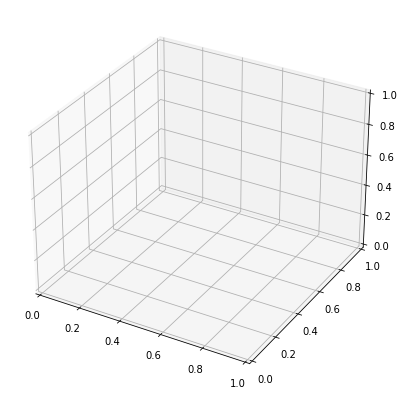

In [111]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=1000, z = z_arra, U = U_array, psi = 0)

## 1.2.7) Cut along kx=0

In [112]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [113]:
def plot_k_w_spec(k, w, spec, disp_filter=False, extent=[-0.4, 0.4, 0, 1.3], ax=None, cmap='viridis'):  
    ax = plotting_interface.plot_3d_as_2d(k, w, spec, disp_filter, extent, ax, cmap=cmap)    
    ax.set_xlabel(r'$k~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$\omega~[\mathrm{rad~Hz}]$')
    return ax

<AxesSubplot:xlabel='$k~[\\mathrm{rad~m}^{-1}]$', ylabel='$\\omega~[\\mathrm{rad~Hz}]$'>

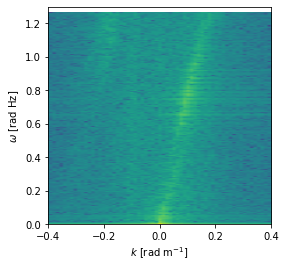

In [114]:
plot_k_w_spec( Kx , w,  np.log10(power_Spectrum[ len(Ky)//2 +0 , : , : ]))

In [353]:
w

array([-1.27409035, -1.26712811, -1.26016587, -1.25320363, -1.24624138,
       -1.23927914, -1.2323169 , -1.22535466, -1.21839241, -1.21143017,
       -1.20446793, -1.19750569, -1.19054345, -1.1835812 , -1.17661896,
       -1.16965672, -1.16269448, -1.15573223, -1.14876999, -1.14180775,
       -1.13484551, -1.12788326, -1.12092102, -1.11395878, -1.10699654,
       -1.10003429, -1.09307205, -1.08610981, -1.07914757, -1.07218533,
       -1.06522308, -1.05826084, -1.0512986 , -1.04433636, -1.03737411,
       -1.03041187, -1.02344963, -1.01648739, -1.00952514, -1.0025629 ,
       -0.99560066, -0.98863842, -0.98167617, -0.97471393, -0.96775169,
       -0.96078945, -0.9538272 , -0.94686496, -0.93990272, -0.93294048,
       -0.92597824, -0.91901599, -0.91205375, -0.90509151, -0.89812927,
       -0.89116702, -0.88420478, -0.87724254, -0.8702803 , -0.86331805,
       -0.85635581, -0.84939357, -0.84243133, -0.83546908, -0.82850684,
       -0.8215446 , -0.81458236, -0.80762012, -0.80065787, -0.79

# 2.1) Inverted Profile

In [115]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial

def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1
                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

# Example usage:
pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(wavenumbers, np.sqrt(Ux**2+Uy**2))
pPEDM2, pEDM2, eps_PEDM2, eps_EDM2, verbose2 = pedm(wavenumbers, Uy)

## Testing

In [116]:
matlab_ux = np.array([1.29324047095870, -1.89463189363109, -1.69708851869363, -0.669636210830390, -2.75906065502856, -1.94768284605381, -1.66698298781537, -0.899800584589916, 0.0297085589908087, -0.514835078702308, -0.0105890842080116, 0.0759766804549144, -0.0363850496987580, -0.0484059195965528, -0.0103916622911056, -0.0308550721930313, 0.398842029692605, -0.117723340988159, -0.441378683422372, 0.430707406907151, -0.699842772060439, 0.399538248189037, 0.730470696764732, -0.523203395681584, 0.499213099684858])

In [117]:
z = np.linspace(-20, 0, 100)

In [118]:
U1_fun = lambda z: np.polyval(pPEDM1, z)
U2_fun = lambda z: np.polyval(pPEDM2, z)

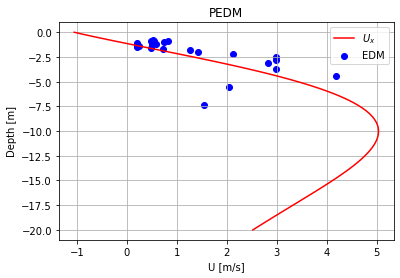

In [119]:
plt.plot(U1_fun(z), z, label="$U_{x}$", color = 'red')
#plt.plot(U2_fun(z), z, label="$U_{y}$", color = 'green')

#plt.scatter(-Ux, -1/(2*wavenumbers), label='EDM', color = 'black')
plt.scatter( np.sqrt(Ux**2+Uy**2), -1/(3.56*wavenumbers), label='EDM', color = 'blue')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

In [120]:
len(verbose1)

1239

In [121]:
pPEDM1

array([ 5.91350657e-11,  1.35175215e-08,  1.26876173e-06,  6.24913404e-05,
        1.69389008e-03,  2.32417033e-02,  9.02125028e-02, -8.48040317e-01,
       -1.05427981e+00])

In [122]:
verbose1[0]

{'pPEDM': array([1.26475174]),
 'pEDM': array([1.26475174]),
 'eps_PEDM': 1.1118373943304174,
 'eps_EDM': 1.1118373943304174,
 'nMax': 0,
 'deltaz_B': 0.2334272498681132,
 'deltaz_T': 0.1167136249340566}

In [823]:
y = np.array([0.17091544, 0.2196002 , 0.24884891, 0.22784447, 0.365201,
       0.37375478, 0.39257039, 0.37231073, 0.41550739, 0.43636989,
       0.45111672, 0.46662792, 0.48854647, 0.49640163, 0.51887196,
       0.52827061, 0.54437941, 0.54929705, 0.56552202, 0.57508514,
      0.58477563, 0.59755615])
x = np.array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
        0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

(-0.05, 0.32)

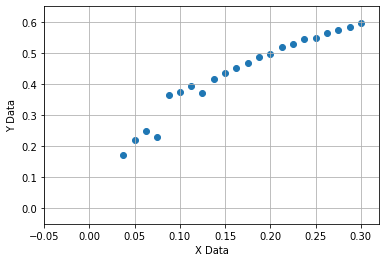

In [832]:
plt.scatter(x, y)

plt.grid(True)
plt.xlabel("X Data")
plt.ylabel("Y Data")

plt.ylim(-0.05,0.65)
plt.xlim(-0.05,0.32)